# Простейшие нейронные сети на PyTorch


Фрэймворком для обучения нейросеток на нашем курсе будет PyTorch. PyTorch стал очень популярным благодаря интуитивно понятной парадигме программирования нейронных сетей, основанной на динамическом графе. Не так давно PyTorch создал свою экосистему https://pytorch.org/ecosystem/, которая содержит в себе библиотеки, решающие практически всевозможные задачи машинного обучения. 

Чтобы установить библиотеку PyTorch, отправляйтесь в консоль и пропишите 

```
Для Windows без GPU
pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Для Windows c GPU
pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Для Linux без GPU
pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Для Linux c GPU
pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Для Mac
pip install torch torchvision

pip install pytorch-lightning
```


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [39]:
# Подгружаем pytorch 
import torch


print(torch.__version__)

1.8.1+cu101


In [3]:
print(torchvision.__version__)

0.9.1+cu101


In [4]:
# Подгрузим ещё немного пакетов :) 
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

%matplotlib inline

## 1. О данных и бэйзлайнах

Наша главная цель - познакомиться с процессом создания простой нейронной сети и ее обучения.

__Делать всё это мы будем на животных.__ Ежегодно около 7.6 миллионов бедных животных в США оказываются в приютах. Часть из них находит себе новую семью, часть возвращается к старому (бывает, что питомец потерялся и его нашли на улице), а часть погибает. Ужегодно усыпляется около 2.7 млн. собак и кошек.  

Используя датасет с входной информацией (цвет, пол, возраст и т.п.) из одного из приютов, мы попытаемся спрогнозировать что произойдёт с новыми животными, которые попадут в этот приют. Данные, используемые в тетрадке уже были предварительно обработаны и приведены в удобную для построения моделей форму. 

In [5]:
X = pd.read_csv('data/X_cat.csv', sep = '\t', index_col=0)
target = pd.read_csv('data/y_cat.csv', sep = '\t', index_col=0, names=['status'])

print(X.shape)
X.head()

(26729, 37)


,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,...,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,1,365.0,1,7,0.000157,1,0.032919,0.463624,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,365.0,1,5,0.000655,0,0.008092,0.015005,1,1,...,1,0,0,0,0,0,0,0,0,1
2,1,730.0,1,6,0.000052,1,0.026293,0.357521,0,1,...,1,0,0,0,0,0,0,0,1,0
3,0,21.0,0,7,0.285871,0,0.000471,0.058418,0,1,...,0,1,0,0,0,0,0,1,0,0
4,1,730.0,0,7,0.285871,0,0.023831,0.075353,0,0,...,1,0,0,0,0,0,0,1,0,0


В датасете находится около 27 тысяч наблюдений и 39 регрессоров. Посмотрим на то как выглядит распределение того, что произошло со зверятами по особям.

In [6]:
target.status.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: status, dtype: int64

Видим, что классы несбалансированы. Попробуем оставит четыре класса и объединить класс умерших животных с классом животных, которых усыпили. 

In [7]:
target = target.iloc[:, :]
target[target == 'Died'] = 'Euthanasia'

Закодируем классы.

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(target)
y

array([2, 1, 0, ..., 0, 3, 3])

In [9]:
len(y)

26729

In [10]:
X.shape

(26729, 37)

Разобьём выборку на тренировочную и тестовую. 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(21383, 37)
(5346, 37)


Прежде, чем учить 228-слойных монстров, давайте построим какие-нибудь простые прогнозы, чтобы было с чем сравнить. Давайте построи наивный прогноз, а также обучим линейную регрессию и случайный лес.

### Константный прогноз

Построим константный прогноз, чтобы было с чем сравнивать и прогноз по какой-нибудь модели. 

In [12]:
from sklearn.metrics import log_loss

probas = np.array(pd.Series(y_train).value_counts(normalize=True).sort_index().tolist())
probas

array([0.40289015, 0.0655661 , 0.17906748, 0.35247627])

In [13]:
log_loss(y_test, np.tile(probas, X_test.shape[0]).reshape(X_test.shape[0], 4))

1.2202552496487795

### Логистическая регрессия

In [14]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression( )
logreg.fit(X_train, y_train)
log_loss(y_test, logreg.predict_proba(X_test))

1.0690596777278318

In [15]:
logreg.predict_proba(X_test) # 4 колонки, по одной на каждый класс

array([[0.18708456, 0.06705535, 0.04653713, 0.69932297],
       [0.71548299, 0.02923457, 0.10843288, 0.14684956],
       [0.52376757, 0.03809996, 0.18068531, 0.25744715],
       ...,
       [0.77510278, 0.01024982, 0.17601912, 0.03862828],
       [0.22847273, 0.05774367, 0.03826679, 0.67551682],
       [0.66540577, 0.03012225, 0.12082838, 0.1836436 ]])

### Случайный лес 

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, n_jobs=3)
rf.fit(X_train, y_train)
log_loss(y_test, rf.predict_proba(X_test))

0.7560520216934784

Неплохой результат. Попробуем улучшить его с помощью нейросеток. 

## 2. Собираем свою нейросеть

In [131]:
INPUT_SIZE = 37
HIDDEN_SIZE = 37
OUTPUT_SIZE = 4
LEARNING_RATE = 1e-3
EPOCHS = 500
BATCH_SIZE = 128

# FAST.AI

In [ ]:
from fastai.tabular.all import *

Загрузим датасет, где необходимо предсказать, будет ли человек зарабатывать больше $50K в год.

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)
path.ls()

(#3) [Path('/home/firiuza/.fastai/data/adult_sample/export.pkl'),Path('/home/firiuza/.fastai/data/adult_sample/adult.csv'),Path('/home/firiuza/.fastai/data/adult_sample/models')]

In [ ]:
df = pd.read_csv(path/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [ ]:
dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

In [ ]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [ ]:
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
                   cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
                   cont_names = ['age', 'fnlwgt', 'education-num'],
                   y_names='salary',
                   splits=splits)

In [ ]:
dls = to.dataloaders(bs=BATCH_SIZE)

In [ ]:
learn = tabular_learner(dls, metrics=accuracy)

In [ ]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.368254,0.356862,0.833538,00:21
1,0.358591,0.346139,0.836302,00:21


In [ ]:
learn.show_results()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary,salary_pred
0,5.0,12.0,5.0,7.0,5.0,5.0,1.0,-0.778299,-0.053376,-0.416371,0.0,0.0
1,5.0,16.0,3.0,9.0,1.0,5.0,1.0,-1.219213,-1.222706,-0.026562,0.0,0.0
2,5.0,7.0,3.0,7.0,1.0,5.0,1.0,1.426273,-0.837421,-1.975608,0.0,0.0
3,5.0,8.0,1.0,2.0,5.0,5.0,1.0,-0.998756,-1.529225,0.753056,0.0,0.0
4,5.0,9.0,3.0,11.0,1.0,5.0,1.0,-0.116927,0.568415,0.363247,1.0,1.0
5,1.0,12.0,3.0,1.0,1.0,5.0,1.0,1.867188,-1.319054,-0.416371,0.0,0.0
6,5.0,12.0,5.0,9.0,4.0,5.0,1.0,-0.925270,-0.339810,-0.416371,0.0,0.0
7,5.0,12.0,6.0,13.0,5.0,5.0,1.0,-1.219213,-0.067373,-0.416371,0.0,0.0
8,5.0,12.0,1.0,9.0,5.0,5.0,1.0,-0.557842,-0.221131,-0.416371,0.0,0.0


In [ ]:
row, clas, probs = learn.predict(df.iloc[0])

In [ ]:
row.show()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,Assoc-acdm,Married-civ-spouse,#na#,Wife,White,False,49.0,101320.001177,12.0,>=50k


# Vanilla PyTorch

Код представленный выше от fastai значительно упрощает работу с нейронными сетями, но не дает понять, что же происходит на самом деле. Поэтому на первых порах лучше все писать самим. Для этого обратимся к первоисточнику, а именно к оригинальному PyTorch, с которого все началось. И для начала разберем все этапы работы с нейронной сети в упрощенной форме. 

!["Pipeline"](./images/Pipeline.png 'Pipeline')

In [38]:
import torch.nn as nn # содержит функции для реалзации архитектуры нейронных сетей
import torch.nn.functional as F # содержит различные функции активации и не только
import torch.optim as optim
import torch.utils.data as data_utils

from pytorch_lightning.metrics import Accuracy


Для того чтобы подавать данные в нейронную сеть, создадим `DataLoader`, который предоставляет гибкий API для работы с входными данными.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :].values, y,
                                                    test_size=0.2, stratify=y, random_state=42)

Создание __DataLoader__ для обучения сети

In [20]:
def create_data_loader(X_train, y_train, X_test, y_test):
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)
    return train_loader, test_loader

In [21]:
train_loader, test_loader = create_data_loader(X_train, y_train, X_test, y_test)

__Архитектура модели__

Архитектуру нейронной сети в PyTorch можно описать нескольками способами, в дальнейшем мы рассмотрим их более подробно. Сейчас предлагается сделать это используя `Sequential`.
`Sequential` -- это последовательный способ объявления каждой компоненты архитектуры нейронной сети.

In [139]:
def build_model():
    model = nn.Sequential(  
        # Добавляем в нашу модель первый слой из 37 нейронов
        nn.Linear(in_features=INPUT_SIZE, out_features=HIDDEN_SIZE),
        nn.ReLU(),
        
        # Добавляем ещё один слой из 37 нейронов
        nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
        nn.ReLU(),
        
        nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
        nn.ReLU(),
        
        nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
        nn.ReLU(),
        
        nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
        nn.ReLU(),
         
        nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
        nn.ReLU(),
        
        nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
        nn.ReLU(),
        
        nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
        nn.ReLU(),
        
        nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
        nn.ReLU(),
        
        
        # Выходной вектор на количество классов, получаем с помощью такого же линейного приеобразования,
        # как и предыдущие слои, но уже на нужное количество выходных нейронов (т.е. классов)
        nn.Linear(in_features=HIDDEN_SIZE, out_features=OUTPUT_SIZE)
    )

    return model

Функция `Linear` представляет собой полносвязный слой, где присутствуют обучаемая матрица и обучаемый баес.

!["FC layer"](./images/FClayer.png 'FC layer')

In [140]:
model = build_model()

In [141]:
print(model)

Sequential(
  (0): Linear(in_features=37, out_features=37, bias=True)
  (1): ReLU()
  (2): Linear(in_features=37, out_features=37, bias=True)
  (3): ReLU()
  (4): Linear(in_features=37, out_features=37, bias=True)
  (5): ReLU()
  (6): Linear(in_features=37, out_features=37, bias=True)
  (7): ReLU()
  (8): Linear(in_features=37, out_features=37, bias=True)
  (9): ReLU()
  (10): Linear(in_features=37, out_features=37, bias=True)
  (11): ReLU()
  (12): Linear(in_features=37, out_features=37, bias=True)
  (13): ReLU()
  (14): Linear(in_features=37, out_features=37, bias=True)
  (15): ReLU()
  (16): Linear(in_features=37, out_features=37, bias=True)
  (17): ReLU()
  (18): Linear(in_features=37, out_features=4, bias=True)
)


На лекции была представлена возможная архитектура сети для задачи классификации. Сейчас мы тоже собрали свою сеть с одним скрытым слоем.

!["Net Arch"](./images/MLP2.jpg 'Network Architecture')

Обратите внимание, что последняя функция в в архитектуре сети -- это `Softmax`. Напомним, что `Softamx` используется для задачи классификации, чтобы получить значение увернности сети по каждому классу. Получается вектор на заданное количество классов, где наибольшее значение в какой-либо координате говорит о том, что сеть считает данный класс наиболее подходящим для данного наблюдения.

!["Softmax"](./images/Softmax.png 'Softmax')

Отлично! Только что мы собрали свою первую нейросеть со скрытым слоем. Осталось ее обучить.

__Обучение модели__

Перед тем как обучать нашу нейросеть, нужно задать параметры обучения. 
- Во-первых, метод оптимизации. 
- Во-вторых, функцию потерь. 
- В-третьих, парочку метрик, на которые нам хотелось бы смотреть в процессе обучения.  

In [142]:
criterion = nn.CrossEntropyLoss()
accuracy = Accuracy()

softmax = nn.Softmax()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Создадим массивы, куда будем складывать значение целевой функции на обучающей и валиационной выборках, а также точность.

Ниже представлен код __обучения__ сети. Нужно обратить внимание на несколько моментов:
1. Обучение ведется в течение нескольких эпох -- что значит несколько проходов по выборке.
2. `train_loader` позволяет итеративно проходится по выборке и на каждой итерации получать батч заранее заданного размера.
3. На каждом шаге обнуляем градиенты `optimizer.zero_grad()`, чтобы не накапливать их, тем самым неккоректно обновлять веса.
4. Вызывать явно `loss.backward()` для вычисления градиентов.
5. Вызывать явно `optimizer.step()` для обновления весов.

In [143]:
step = 0
train_loss_values = []
train_accuracy_values = []
valid_loss_values = []
valid_accuracy = []

def run_train():
    step = 0
    for epoch in range(EPOCHS):
        running_loss = []
        running_acc = []
        model.train()
        for features, label in train_loader:
            # Reset gradients
            optimizer.zero_grad()

            output = model(features)
            # Calculate error and backpropagate
            loss = criterion(output, label.long())
            loss.backward()

            output = softmax(output)

            acc = accuracy(output, label.long()).item()

            # Update weights with gradients
            optimizer.step()

            running_loss.append(loss.item())
            running_acc.append(acc)

            step += 1

        train_loss_values.append(np.mean(running_loss))
        train_accuracy_values.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d : train_loss: %f train_acc: %f' % (epoch, train_loss_values[-1], train_accuracy_values[-1]))


        # Run validation
        running_loss = []
        running_acc = []
        model.eval()
        for features, label in test_loader:
            output = model(features)
            # Calculate error and backpropagate
            loss = criterion(output, label.long())
            output = softmax(output)
            acc = accuracy(output, label.long()).item()

            running_loss.append(loss.item())
            running_acc.append(acc)

        valid_loss_values.append(np.mean(running_loss))
        valid_accuracy.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d : valid_loss: %f valid_acc: %f' % (epoch, valid_loss_values[-1], valid_accuracy[-1]))
        
    return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy

In [144]:
train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy = run_train()

EPOCH 0 : train_loss: 1.151309 train_acc: 0.420546
EPOCH 0 : valid_loss: 1.122872 valid_acc: 0.508655
EPOCH 20 : train_loss: 0.883259 train_acc: 0.621492
EPOCH 20 : valid_loss: 0.993573 valid_acc: 0.580668
EPOCH 40 : train_loss: 0.860473 train_acc: 0.630122
EPOCH 40 : valid_loss: 0.867070 valid_acc: 0.638719
EPOCH 60 : train_loss: 0.844121 train_acc: 0.639117
EPOCH 60 : valid_loss: 0.887825 valid_acc: 0.618630
EPOCH 80 : train_loss: 0.840407 train_acc: 0.642100
EPOCH 80 : valid_loss: 0.900925 valid_acc: 0.597239
EPOCH 100 : train_loss: 0.828758 train_acc: 0.647155
EPOCH 100 : valid_loss: 0.850400 valid_acc: 0.642683
EPOCH 120 : train_loss: 0.820091 train_acc: 0.650364
EPOCH 120 : valid_loss: 0.883924 valid_acc: 0.638161
EPOCH 140 : train_loss: 0.805744 train_acc: 0.656516
EPOCH 140 : valid_loss: 0.827502 valid_acc: 0.658049
EPOCH 160 : train_loss: 0.797945 train_acc: 0.660934
EPOCH 160 : valid_loss: 0.822057 valid_acc: 0.663072
EPOCH 180 : train_loss: 0.805534 train_acc: 0.652955
EPOCH

 Посмотрим на динамику ошибки и значение точности нашей модели во времени.

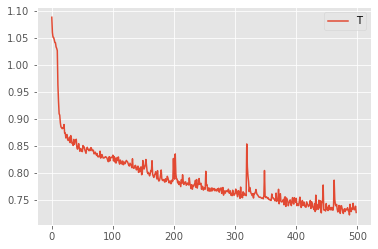

In [145]:
start = 1
plt.plot(train_loss_values[start:])
plt.legend('Train loss')

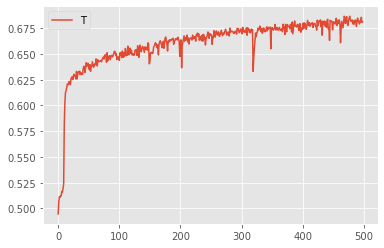

In [146]:
start = 1
plt.plot(train_accuracy_values[start:])
plt.legend('Train accuracy')

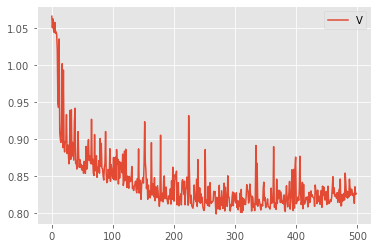

In [147]:
plt.plot(valid_loss_values[start:])
plt.legend('Validation loss')

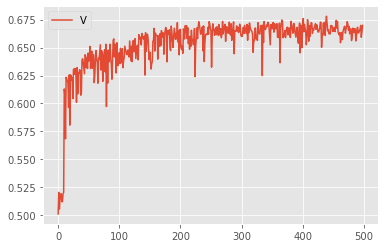

In [148]:
plt.plot(valid_accuracy[start:])
plt.legend('Validation accuracy')

Сохраним модель. Файл может иметь два расширения, как .pt, так и .pth. 

In [149]:
torch.save(model, 'simple_nn2.pth')

Теперь загрузим сохраненную модель и посмотрим на ее предсказания. Важно! Когда идет этап inference модели, то нужно явно вызвать `model.eval()`, так как в случае если есть droupout или batch norm, то они не дложны работать как в процессе обучения, иначе они продолжат обучаться. 

In [150]:
model = torch.load('simple_nn2.pth')
model.eval()

Sequential(
  (0): Linear(in_features=37, out_features=37, bias=True)
  (1): ReLU()
  (2): Linear(in_features=37, out_features=37, bias=True)
  (3): ReLU()
  (4): Linear(in_features=37, out_features=37, bias=True)
  (5): ReLU()
  (6): Linear(in_features=37, out_features=37, bias=True)
  (7): ReLU()
  (8): Linear(in_features=37, out_features=37, bias=True)
  (9): ReLU()
  (10): Linear(in_features=37, out_features=37, bias=True)
  (11): ReLU()
  (12): Linear(in_features=37, out_features=37, bias=True)
  (13): ReLU()
  (14): Linear(in_features=37, out_features=37, bias=True)
  (15): ReLU()
  (16): Linear(in_features=37, out_features=37, bias=True)
  (17): ReLU()
  (18): Linear(in_features=37, out_features=4, bias=True)
)

In [151]:
# Выход модели (вероятность) на тестовой выборке
with torch.no_grad():
    test_scores = softmax(model(torch.tensor(X_test.astype(np.float32))))
print(accuracy(test_scores, torch.tensor(y_test.astype(np.int))).item())
print(test_scores.numpy())

0.6702207326889038
[[9.3612224e-01 7.2332053e-03 3.3667887e-04 5.6307942e-02]
 [4.8898768e-01 4.0737964e-02 2.6946378e-01 2.0081061e-01]
 [8.9662391e-01 7.7835680e-04 6.0685212e-03 9.6529216e-02]
 ...
 [2.8649288e-01 4.9483334e-04 1.4747077e-01 5.6554151e-01]
 [9.9406224e-01 9.0056463e-05 2.6322762e-04 5.5845524e-03]
 [9.9859113e-01 3.1441692e-07 4.7466785e-04 9.3391322e-04]]


In [152]:
# Предсказание классов на тестовой выборке
with torch.no_grad():
    test_scores = softmax(model(torch.tensor(X_test.astype(np.float32))))
predicted_classes = torch.argmax(test_scores, dim=1)
print(predicted_classes)

tensor([0, 0, 0,  ..., 3, 0, 0])


 Если `loss` еще падает, то точность не растет. __Как думаете, с чем это может быть связано?__

ОТВЕТ: Это может быть из-за функции потерь. Функция потерь рассчитывается с использованием фактических предсказанных вероятностей, в то время как точность рассчитывается с использованием одного значения, у которого вероятность максимальна(argmax).

__Домашнее задание.__
Нужно обучить нейронную сеть, точность классификация должна быть не меньше __60%__. Как это можно получить:
1. Посмотрите на данные, характеристики.
2. Попробуйте менять гиперпараметры сети.
3. Обратите внимание на саму архитектуру сети.
4. Сделайте подсчет точности на валидационной выборке не через DataLoader.

РЕШЕНИЕ: 
Была улучшена модель:
1. Небольшой дисбаланс классов, как вариант можно использовать f1 score в качестве метрики качества
2. Увеличено число эпох (500 эпох) и количество скрытых нейронов в скрытых слоях(37)
3. Добавлено больше слоев в нейросеть(теперь их 10), изменена функция активации с Sigmoid на ReLU(чтобы не было затухания градиента), изменен оптимизатор с SGD на Adam(для ускорения сходимости). 
Также был опробован dropout с p=0.25, но он только ухудшил результат
4. Подсчет точности на валидационной выборке:

In [153]:
#accuracy без DataLoader'а
print((predicted_classes == torch.Tensor(y_test)).float().mean())

tensor(0.6702)


In [160]:
#f1-score
from sklearn.metrics import f1_score

f1_score(np.array(y_test), np.array(predicted_classes), average='weighted')

0.6579190376714259